In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/quora-question-pairs'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


## Data Structure 

In [3]:
# Unzip the input data file
import zipfile

filezip = filenames # get a list of all file in folder quora-question-pairs

for fz in filezip:
    if fz.endswith(".zip"): # check the suffixe '.zip'
        zFile = zipfile.ZipFile(dirname + "/" + fz,"r") # Zipfile Open a ZIP file
        for fileM in zFile.namelist(): # .namelist() Return a list of archive members by name.
            zFile.extract(fileM,"/kaggle/working")# .extract Extract a member from the archive to the current working directory

In [4]:
# Load the train set 
df_train = pd.read_csv("/kaggle/working/train.csv")
df_train.shape

(404290, 6)

We can see the Quora Question consists of 404,290 raws and 6 columns.

In [5]:
# Summary statistics
df_train.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614503,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [6]:
# Information 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [7]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
# Inspecting missing values 
df_train.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [9]:
# Remove the missing values
df_train = df_train.dropna(how='any').reset_index(drop=True)

Let's see the sample sentences :

In [10]:
# df.iloc[:10, [3,4]]
for i in range(0, 10):
    print(df_train['question1'][i])
    print(df_train['question2'][i])
    print("\n")

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?


What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?


How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?


Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?


Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Which fish would survive in salt water?


Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?


Should I buy tiago?
What keeps childern active and far from phone and video games?


How can I be a good geologist?
What should I do to be a great geologist?


When do you use 

## Similarities Distributions 

Plot the distribution of the sentence duplicate or non duplicate : 

In [11]:
df_train['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

In [13]:
# calculate the proportion 

df_train['is_duplicate'].value_counts() / len(df_train) * 100 

0    63.079941
1    36.920059
Name: is_duplicate, dtype: float64

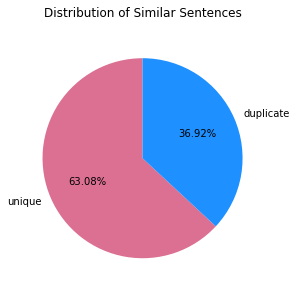

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,5))
labels = ["unique", "duplicate"]
sizes = df_train['is_duplicate'].value_counts()
colors = ['palevioletred','dodgerblue']

plt.title("Distribution of Similar Sentences")
patches,text1,text2 = plt.pie(sizes,
                      explode=None,
                      labels=labels,
                      colors=colors,
                      autopct = '%1.2f%%', 
                      shadow = False, 
                      startangle =90, 
                      pctdistance = 0.6) 

plt.axis('equal')
plt.show()

Then, let's draw a plot to visualize the correlation of word's length and the similarities : 

In [15]:
# The length of words
df_train['len_w_q1'] = df_train['question1'].apply(lambda x : len(str(x).split()))
df_train['len_w_q2'] = df_train['question2'].apply(lambda x : len(str(x).split()))

In [16]:
# Find common words 
df_train['common_words'] = df_train.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)

In [17]:
# Import plotly

import plotly.express as px
px.histogram(df_train, x="len_w_q1",height=700, color='is_duplicate', title="Question1 Length Distribution", marginal="box")

In [18]:
px.histogram(df_train, x="len_w_q2",height=700, color='is_duplicate', title="Question2 Length Distribution", marginal="box")

As we can see from the boxplot and histogram, the data is skewed to the right as the tail is longer. The distribution of similar sentences is more in the sentences of relatively short in length.

## Word Cloud

In [19]:
# Import regex
import re 

def text_cleaning(x):
    
    questions = re.sub('\s+\n+', ' ', x)
    questions = re.sub('[^a-zA-Z0-9]', ' ', questions)
    questions = questions.lower()
    
    return questions

In [20]:
# Import tqdm to show the small progress 
from tqdm import tqdm
tqdm.pandas()

df_train['q1_cleaned'] = df_train['question1'].progress_apply(text_cleaning)
df_train['q2_cleaned'] = df_train['question2'].progress_apply(text_cleaning)

100%|██████████| 404287/404287 [00:03<00:00, 111796.84it/s]


## Word2Vec modeling 

Word2Vec is a more sophisticated word embedding technique. This technique is based on the idea that words that occur in the same contexts tend to have similar meanings.   

So if two words have similar contexts, then our network is motivated to learn similar word vectors for these two words.

Simple graphic Word2Vec :

**CBOW model** & **skip gram model**

![](https://blog.acolyer.org/wp-content/uploads/2016/04/word2vec-cbow.png)

![](https://blog.acolyer.org/wp-content/uploads/2016/04/word2vec-skip-gram.png)

Ref : [The amazing power of word vectors](http://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/)

We will be using word2vec pre-trained **Google News corpus**. 

In [21]:
# Import KeyedVectors

from gensim.models.keyedvectors import KeyedVectors
model = KeyedVectors.load_word2vec_format('/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin', binary=True)

In [22]:
#  Obtain sentence vector from word vector

import gensim
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


def sent2vec(s):
    token_list = gensim.utils.simple_preprocess(str(s).encode('utf-8'))
   
    words = [w for w in token_list if w not in stop_words]
    words = [w for w in words if w.isalpha()]
    
    words_vectors = []
    for w in words:
        try:
            words_vectors.append(model[w])
        except:
            continue 
    # Summing the resulting word vectors and divide by the total number of vectors 
    # There are 300 vectors in Google's pre-trained model
    words_vectors = np.array(words_vectors)
    add_up_vectors = words_vectors.sum(axis=0)
    sent_vectors = add_up_vectors / words_vectors.shape[0]
    return sent_vectors

In [23]:
np.seterr(all='ignore', divide='ignore')

q1_train_vectors = np.zeros((df_train.shape[0], 300))

for i, q in enumerate(tqdm(df_train['q1_cleaned'].values)):
    q1_train_vectors[i,:] = sent2vec(q)

100%|██████████| 404287/404287 [00:35<00:00, 11470.01it/s]


In [24]:
q2_train_vectors = np.zeros((df_train.shape[0], 300))

for i, q in enumerate(tqdm(df_train['q2_cleaned'].values)):
    q2_train_vectors[i,:] = sent2vec(q)

100%|██████████| 404287/404287 [00:35<00:00, 11529.23it/s]


We now obtain the vector of sentences for question1 and question2, then we compute all the distances.

In [25]:
from scipy.spatial.distance import cosine

In [26]:
df_train['cosine_distance'] = [cosine(q1, q2) for (q1, q2) in zip(np.nan_to_num(q1_train_vectors), np.nan_to_num(q2_train_vectors))]

# Removing the Nan entries or infs entries

In [28]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_w_q1,len_w_q2,common_words,q1_cleaned,q2_cleaned,cosine_distance
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14,12,10,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0.068972
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,8,13,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0.307825
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,14,10,4,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0.222009
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,11,9,0,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0.654169
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,13,7,2,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0.369993


In [29]:
df_train.isnull().sum()

id                 0
qid1               0
qid2               0
question1          0
question2          0
is_duplicate       0
len_w_q1           0
len_w_q2           0
common_words       0
q1_cleaned         0
q2_cleaned         0
cosine_distance    0
dtype: int64

In [30]:
df_train.drop(['question1', 'question2','q1_cleaned', 'q2_cleaned', 'qid1', 'qid2'], axis=1, inplace=True)

In [31]:
df_train.head()

,id,is_duplicate,len_w_q1,len_w_q2,common_words,cosine_distance
0,0,0,14,12,10,0.068972
1,1,0,8,13,4,0.307825
2,2,0,14,10,4,0.222009
3,3,0,11,9,0,0.654169
4,4,0,13,7,2,0.369993


In [32]:
X = df_train.loc[:, df_train.columns != 'is_duplicate']
y = df_train.loc[:, df_train.columns == 'is_duplicate']

In [34]:
X.shape

(404287, 5)

In [35]:
y.shape

(404287, 1)

## RandomForestClassifier

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [39]:
# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0,1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

In [47]:
model = RandomForestClassifier(n_estimators=80, max_depth=40, random_state=42)
model.fit(rescaledX_train, y_train.values.ravel())

RandomForestClassifier(max_depth=40, n_estimators=80, random_state=42)

In [48]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

In [49]:
prediction = model.predict(rescaledX_test)
cm = confusion_matrix(y_test, prediction)  
print(cm)  
print('Accuracy', accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))

[[58404 18243]
 [18191 26449]]
Accuracy 0.6996050689686446
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     76647
           1       0.59      0.59      0.59     44640

    accuracy                           0.70    121287
   macro avg       0.68      0.68      0.68    121287
weighted avg       0.70      0.70      0.70    121287

